In [116]:
import numpy as np
import matplotlib.pyplot as plt

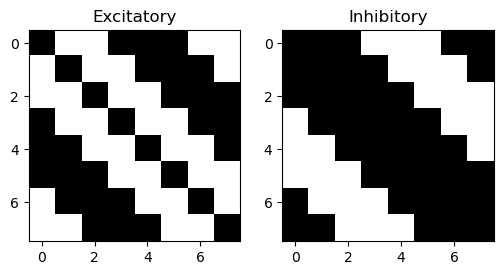

In [123]:
## Head-Direction Ring Attractor Model

# Parameters
N = 8 # number of neurons
Exc = 2 # Excitation distance
Inh = 4 # Inhibition distance

# Connectivity matrix
C_inh = np.zeros((N,N))
C_exc = np.zeros((N,N))

# Fill connectivity matrices
for i in range(-Exc,N+Exc):
    for j in range(-Exc,N+Exc):
        if i==j:
            continue
        if abs(i-j) <= Exc:
            C_exc[i%N,j%N] = 1

for i in range(-Inh,N+Inh):
    for j in range(-Inh,N+Inh):
        if i==j or abs(i-j) <= Exc:
            continue
        if abs(i-j) <= Inh:
            C_inh[i%N,j%N] = 1
            
# Plot connectivity matrices
fig, ax = plt.subplots(1,2, figsize=(6,3))
ax[0].imshow(C_exc, cmap='gray')
ax[0].set_title('Excitatory')
ax[1].imshow(C_inh, cmap='gray')
ax[1].set_title('Inhibitory')
plt.show()

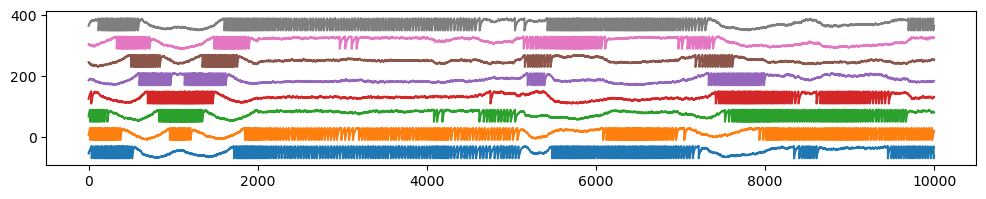

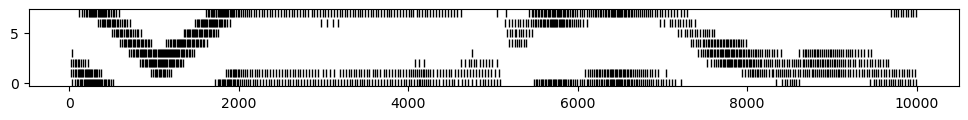

In [125]:
# LIF neuron model (with noise)
tau = 2 # ms

tau_inh = 5 # ms
tau_exc = 5 # ms

Cm = 1 # nF

dt = 0.1 # ms
theta = -30 # mV
reset = -70 # mV

leak_voltage = -55 # mV
inh_voltage = -70 # mV
exc_voltage = 0 # mV

inh_conductance = 15.0
exc_conductance = 5.0

noise_scale = 10

# sinusoidal input
I_ext = 15 # nA

def lif_update(x,inh_gate,exc_gate,phase, I_max):
    I_leak = - (x-leak_voltage)/tau
    I_inh = - inh_conductance * inh_gate * (x-inh_voltage)
    I_exc =  - exc_conductance * exc_gate * (x-exc_voltage)
    I_hd = I_max * np.sin(2*np.pi*np.linspace(0,1,N) + phase)

    x += dt/tau * (I_leak + I_inh + I_exc + np.random.randn(N)*noise_scale + I_ext + I_hd)
    inh_gate += dt/tau_inh * (-inh_gate + C_inh @ (x>theta))
    exc_gate += dt/tau_exc * (-exc_gate + C_exc @ (x>theta))
    x[x>theta] = reset
    return x,inh_gate,exc_gate

phase = 2*np.pi*np.random.rand()

# Simulation
T = 10000
xs = np.zeros((T,N))
inh_gates = np.zeros((T,N))
exc_gates = np.zeros((T,N))
spikes = np.zeros((T,N))

xs[0,:] = leak_voltage * np.ones(N)
phase = 0 
for t in range(1,T):
    if t<1000:
        phase += 0.001
        I_max = 20 # nA
    elif t<2000:
        phase -= 0.001
        I_max = 20 # nA
    elif t<3000:
        phase = 0
        I_max = 0
    elif t>4000:
        phase += 0.0005
        I_max+=0.5*np.random.randn()

    xs[t,:],inh_gates[t,:],exc_gates[t,:] = lif_update(xs[t-1,:],inh_gates[t-1,:],exc_gates[t-1,:],phase*2*np.pi, I_max)
    spikes[t,:] = xs[t,:] == reset

# Plot
plt.figure(figsize=(12,2))
for i in range(N):
    plt.plot(xs[:,i]+i*60)
plt.show()

#plot spikes as raster
plt.figure(figsize=(12,1))
for i in range(N):
    plt.plot(np.where(spikes[:,i]==1)[0],i*np.ones(np.sum(spikes[:,i]==1)),'k|')